In [1]:
import os
import pandas as pd
import numpy as np
from typing import Dict, List
import importlib
from pathlib import Path
import matplotlib.pyplot as plt
import MeCab
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
import os
import yaml
os.environ["WANDB_NOTEBOOK_NAME"] = (
    "/home/masa1357/Dockerdata/gitfile/Tree-Model/src/sweep.ipynb"
)

In [2]:
# INFO: import local libraries
import python.data_manager as dm
import python.Mecab_processing as mp
import python.util as util

In [3]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "model"
print(f"BASE_PATH: {BASE_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODEL_PATH: {MODEL_PATH}")

BASE_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model
DATA_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model/data
MODEL_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model/model


In [4]:
importlib.reload(util)
# ? logger読み込み
name = "15-Ensemble"
logger = util.set_logger()
# ? seed値固定
seed = 42
util.set_seed(seed)

2024-08-15 02:41:50,560 : python.util : INFO : 34 : Test_message


In [5]:
# ? データ読み込み
# import python.data_manager as dm

importlib.reload(dm)
# argsでloggerの名前を送る
args: Dict[str, object] = {
    "logger": logger,
    "DATA_PATH": DATA_PATH,
    "key": "userid",
    "text": "answer_content",
    "label": "grade",
    "mode": "train-valid",
    "split_rate": [0.8, 0.2, 0],
    "seed": seed,
}

with util.timer("load data"):
    dp = dm.DataProcessing(args)
    train, valid = dp()

2024-08-15 02:41:50,568 : python.util.python.data_manager : INFO : 16 : setup Child logger : python.data_manager
2024-08-15 02:41:50,568 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection *.csv data...
2024-08-15 02:41:50,570 : python.util.python.data_manager : INFO : 67 : Found files: [PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2021-2_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2022-1_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2021-1_Reflection.csv')]
2024-08-15 02:41:50,648 : python.util.python.data_manager : INFO : 74 : Total rows: 28275
2024-08-15 02:41:50,649 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/Tree-Model/data/Grade *.csv data...
2024-08-15 02:41:50,650 : python.util.python.data_manager : INFO : 67 : Found files: [PosixPat

[load data] start
[load data] done in 0.71 s


In [6]:
train

,userid,grade,text,course_number,question_number,label
0,C-2022-1_U72,C,情報科学の時間で学習する内容や授業で使う教材システム評価方法の説明,01,1,2
1,C-2021-1_U70,D,授業の説明情報伝達の歴史を大まかに学んだ,01,1,3
2,C-2021-2_U103,B,情報教育が軽視されているが今の世の中で情報について知ることは必須である情報は伝送しやすい形に...,01,1,1
3,C-2021-2_U139,B,情報科学の発展は目覚ましくインタネットを使うことで様々な情報を２進数に変化し扱うことができる...,01,1,1
4,C-2022-1_U7,C,情報科学についてを知ることができました,01,1,2
...,...,...,...,...,...,...
22415,C-2022-1_U89,B,今日は60分間テストの後アンケトに答えて授業が終わるという日でしたので新たに知識を発見すると...,15,5,1
22421,C-2021-2_U46,D,情報量の計算はやりかたを覚えていなかったため解けなかった\r\n他の問題はそれなりに覚えてい...,15,5,3
22422,C-2021-1_U2,A,記述問題が難しかったが計算や選択問題は比較的できたと思う,15,5,0
22423,C-2021-1_U75,B,テストの時間が足りなかったのが残念だった情報科学の授業を通してコンピュタに関わる仕組みの基本...,15,5,1


### 簡単な可視化
- 成績ごとの単語数分布
- 質問ごとの単語数分布
- 講義回数ごとの単語数分布
  

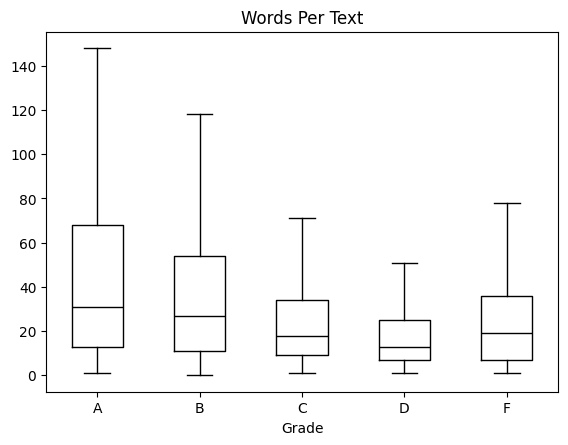

In [7]:
# INFO: 成績ごとの単語数の分布を確認

mecab = MeCab.Tagger()


def count_words(text):
    node = mecab.parseToNode(text)
    word_count = 0
    while node:
        if node.surface:
            word_count += 1
        node = node.next
    return word_count


train["Words Per Text"] = train["text"].apply(count_words)
train.boxplot(
    column="Words Per Text", by="grade", grid=False, showfliers=False, color="black"
)

plt.suptitle("")
plt.xlabel("Grade")
plt.show()

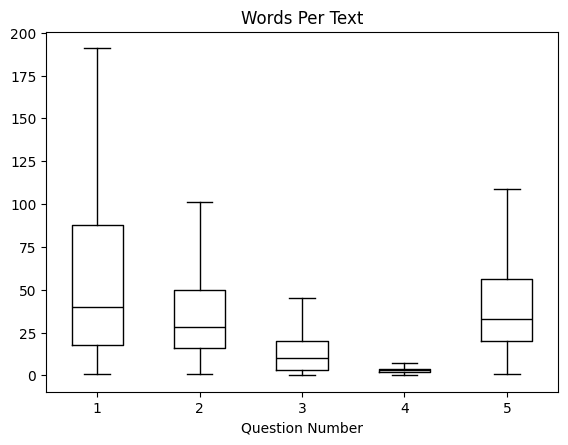

In [8]:
# INFO: 質問ごとの単語数の分布を確認
train.boxplot(
    column="Words Per Text",
    by="question_number",
    grid=False,
    showfliers=False,
    color="black",
)
plt.suptitle("")
plt.xlabel("Question Number")
plt.show()

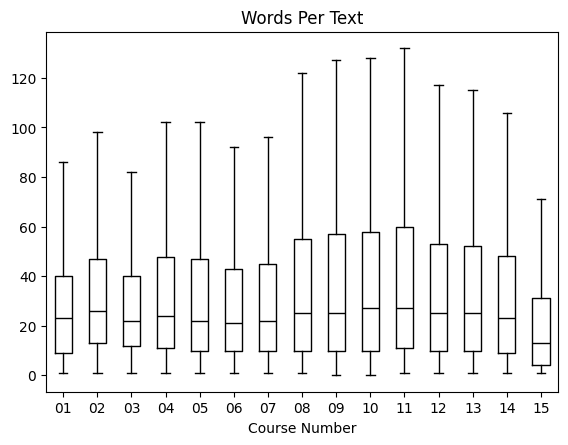

In [9]:
# INFO: 講義回数ごとの単語数の分布を確認
train.boxplot(
    column="Words Per Text",
    by="course_number",
    grid=False,
    showfliers=False,
    color="black",
)
plt.suptitle("")
plt.xlabel("Course Number")
plt.show()

## データを数値化してlightGBMに突っ込む

### 生徒のデータ形式

- `user_1`:
  - 1-1, 1-2, 1-3, 1-4, 1-5  
  - 2-1, 2-2, ..., 2-5  
  - ...  
  - 15-1, ..., 15-5

- `user_2`:
  - ...

- 各生徒の持つデータ数は膨大
- しかし全て有用であるため、とりあえず平均を使用して対応
- 質問番号は"1"のみ用いることとする

In [10]:
Input_df = pd.DataFrame()
Valid_df = pd.DataFrame()

### 1. 各文章の単語数
大事だと思うから，全て突っ込む<br>
数値の動きを擬似的な関数として定義するのもありかもしれないが，あとで考える

In [11]:
filter = "1"
temp = train.copy()
temp["text"] = train["Words Per Text"]
temp.head()

,userid,grade,text,course_number,question_number,label,Words Per Text
0,C-2022-1_U72,C,18,01,1,2,18
1,C-2021-1_U70,D,12,01,1,3,12
2,C-2021-2_U103,B,74,01,1,1,74
3,C-2021-2_U139,B,38,01,1,1,38
4,C-2022-1_U7,C,12,01,1,2,12


In [12]:
Qfilter_df = dm.encode(temp, logger=logger, filter=filter)
Input_df = pd.concat([Input_df, Qfilter_df])
Input_df = Input_df.replace("[NA]", 0)
Input_df.head()

/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,0,0,0,0,0,0,0
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,30,19,14,43,19,23,6
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,38,71,30,64,50,22,38
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,48,70,29,56,75,42,38
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,116,60,76,85,60,72,3


In [13]:
valid["Words Per Text"] = valid["text"].apply(count_words)
temp = valid.copy()
temp["text"] = valid["Words Per Text"]
Qfilter_df = dm.encode(temp, logger=logger, filter=filter)
Valid_df = pd.concat([Valid_df, Qfilter_df])
Valid_df = Valid_df.replace("[NA]", 0)
Valid_df.head()

/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15
0,C-2021-1_U100,2,11,20,6,20,10,6,9,4,7,9,23,17,7,20,2
1,C-2021-1_U101,1,40,103,73,147,92,143,202,150,146,109,218,184,290,170,5
2,C-2021-1_U103,1,33,45,45,51,52,53,96,90,89,91,110,52,50,138,2
3,C-2021-1_U107,2,0,0,0,10,3,15,7,3,1,6,4,5,11,25,2
4,C-2021-1_U12,1,60,10,14,35,29,20,21,9,70,28,107,58,31,73,9


### 2. 各文章内の0の数

In [14]:
Input_df["zero_count"] = Input_df.isin([0]).sum(axis=1)
Valid_df["zero_count"] = Valid_df.isin([0]).sum(axis=1)
Input_df.head()

new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,zero_count
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,0,0,0,0,0,0,0,8
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,30,19,14,43,19,23,6,0
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,38,71,30,64,50,22,38,0
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,48,70,29,56,75,42,38,0
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,116,60,76,85,60,72,3,0


### 3. 各文章のベクトル間距離
多すぎるので，平均 / 中央値で保管する<br>
使うのはユークリッド距離とコサイン距離

In [15]:
args: Dict[str, object] = {
    "logger": logger,
    "MODEL_PATH": MODEL_PATH,
    "seed": seed,
}

with util.timer("Load Model..."):
    gs = mp.GetSentenceVector(args, train[train["question_number"] == filter])

[Load Model...] start


100%|██████████| 3795/3795 [00:00<00:00, 9718.47it/s] 
2024-08-15 02:41:53,533 : python.util.python.Mecab_processing : INFO : 68 : loading word2vec model ...
2024-08-15 02:41:53,559 : python.util.python.Mecab_processing : INFO : 70 : model loaded.


[Load Model...] done in 0.42 s


In [16]:
def cosine_similarity(vec1, vec2):
    # ゼロベクトルのチェック
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0

    # SciPyのコサイン距離を使用してコサイン類似度を計算
    return 1 - distance.cosine(vec1, vec2)

In [17]:
def get_vector_distance(df, filter=1):
    logger.info(f"Start get_vector_distance")
    Enc_df = dm.encode(df=df, logger=logger, filter=filter)
    data_X = {}
    data_Y = {}
    texts = {}

    for j in range(1, 16):
        column_name = f"{j:02d}"
        columns = ["userid", column_name, "label"]
        with util.timer(f"GetSentenceVector:{column_name}"):
            data_X[j], data_Y[j], texts[j] = gs(df=Enc_df[columns], key=column_name)

    logger.info(f"get Euclidean Distance")
    distances_df = pd.DataFrame()
    with util.timer(f"Calculate Euclidean Distance:"):
        # 全ての行に対して繰り返す
        for j in range(len(data_X[1])):
            for i in range(1, 15):
                name = f"euc_{i}:{i+1}"
                vec1 = data_X[i].iloc[j].values
                vec2 = data_X[i + 1].iloc[j].values
                distances_df.loc[j, name] = np.linalg.norm(vec1 - vec2)
            # 全ての列の平均値を計算
            distances_df.loc[j, "euc_mean"] = distances_df.loc[j].mean()
    
    logger.info(f"get Cosine Distance")
    cosdist_df = pd.DataFrame()
    with util.timer(f"Calculate cosine Distance:"):
        for j in range(len(data_X[1])):
            for i in range(1, 15):
                name = f"cos_{i}:{i+1}"
                vec1 = data_X[i].iloc[j].values
                vec2 = data_X[i + 1].iloc[j].values
                cosdist_df.loc[j, name] = 1 - cosine_similarity(vec1, vec2)
            # 全ての列の平均値を計算
            cosdist_df.loc[j, "cos_mean"] = cosdist_df.loc[j].mean()
    cosdist_df["Category"] = data_Y[1]["category_id"]

    # df['Euclidean Distance'] = distances_df["mean"]
    # df['Cosine Distance'] = cosdist_df["mean"]
    
    return distances_df, cosdist_df

In [18]:
te_dist, tc_dist = get_vector_distance(train, filter=filter)
ve_dist, vc_dist = get_vector_distance(valid, filter=filter)

2024-08-15 02:41:53,585 : python.util : INFO : 2 : Start get_vector_distance
/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


[GetSentenceVector:01] start


299it [00:00, 6039.85it/s]


[GetSentenceVector:01] done in 0.07 s
[GetSentenceVector:02] start


299it [00:00, 5081.55it/s]


[GetSentenceVector:02] done in 0.07 s
[GetSentenceVector:03] start


299it [00:00, 6167.37it/s]


[GetSentenceVector:03] done in 0.06 s
[GetSentenceVector:04] start


299it [00:00, 5212.68it/s]


[GetSentenceVector:04] done in 0.07 s
[GetSentenceVector:05] start


299it [00:00, 5206.94it/s]


[GetSentenceVector:05] done in 0.07 s
[GetSentenceVector:06] start


299it [00:00, 4467.33it/s]


[GetSentenceVector:06] done in 0.08 s
[GetSentenceVector:07] start


299it [00:00, 4530.32it/s]


[GetSentenceVector:07] done in 0.08 s
[GetSentenceVector:08] start


299it [00:00, 3722.55it/s]


[GetSentenceVector:08] done in 0.10 s
[GetSentenceVector:09] start


299it [00:00, 3542.36it/s]


[GetSentenceVector:09] done in 0.10 s
[GetSentenceVector:10] start


299it [00:00, 3849.44it/s]


[GetSentenceVector:10] done in 0.09 s
[GetSentenceVector:11] start


299it [00:00, 3229.15it/s]


[GetSentenceVector:11] done in 0.11 s
[GetSentenceVector:12] start


299it [00:00, 4563.65it/s]


[GetSentenceVector:12] done in 0.08 s
[GetSentenceVector:13] start


299it [00:00, 4067.45it/s]


[GetSentenceVector:13] done in 0.09 s
[GetSentenceVector:14] start


299it [00:00, 3927.88it/s]


[GetSentenceVector:14] done in 0.09 s
[GetSentenceVector:15] start


299it [00:00, 23241.66it/s]
2024-08-15 02:41:54,872 : python.util : INFO : 14 : get Euclidean Distance


[GetSentenceVector:15] done in 0.03 s
[Calculate Euclidean Distance:] start


2024-08-15 02:41:55,756 : python.util : INFO : 27 : get Cosine Distance


[Calculate Euclidean Distance:] done in 0.88 s
[Calculate cosine Distance:] start


2024-08-15 02:41:56,707 : python.util : INFO : 2 : Start get_vector_distance
/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


[Calculate cosine Distance:] done in 0.95 s
[GetSentenceVector:01] start


75it [00:00, 5532.21it/s]


[GetSentenceVector:01] done in 0.02 s
[GetSentenceVector:02] start


75it [00:00, 3846.15it/s]


[GetSentenceVector:02] done in 0.03 s
[GetSentenceVector:03] start


75it [00:00, 4668.57it/s]


[GetSentenceVector:03] done in 0.03 s
[GetSentenceVector:04] start


75it [00:00, 3897.47it/s]


[GetSentenceVector:04] done in 0.03 s
[GetSentenceVector:05] start


75it [00:00, 3968.17it/s]


[GetSentenceVector:05] done in 0.03 s
[GetSentenceVector:06] start


75it [00:00, 3581.94it/s]


[GetSentenceVector:06] done in 0.03 s
[GetSentenceVector:07] start


75it [00:00, 3347.91it/s]


[GetSentenceVector:07] done in 0.03 s
[GetSentenceVector:08] start


75it [00:00, 3395.17it/s]


[GetSentenceVector:08] done in 0.03 s
[GetSentenceVector:09] start


75it [00:00, 2208.61it/s]


[GetSentenceVector:09] done in 0.04 s
[GetSentenceVector:10] start


75it [00:00, 2987.59it/s]


[GetSentenceVector:10] done in 0.03 s
[GetSentenceVector:11] start


75it [00:00, 2969.63it/s]


[GetSentenceVector:11] done in 0.03 s
[GetSentenceVector:12] start


75it [00:00, 3329.38it/s]


[GetSentenceVector:12] done in 0.03 s
[GetSentenceVector:13] start


75it [00:00, 3021.66it/s]


[GetSentenceVector:13] done in 0.03 s
[GetSentenceVector:14] start


75it [00:00, 3293.92it/s]


[GetSentenceVector:14] done in 0.03 s
[GetSentenceVector:15] start


75it [00:00, 23057.45it/s]
2024-08-15 02:41:57,186 : python.util : INFO : 14 : get Euclidean Distance
2024-08-15 02:41:57,413 : python.util : INFO : 27 : get Cosine Distance


[GetSentenceVector:15] done in 0.01 s
[Calculate Euclidean Distance:] start
[Calculate Euclidean Distance:] done in 0.23 s
[Calculate cosine Distance:] start
[Calculate cosine Distance:] done in 0.24 s


In [19]:
# Input_df = pd.concat([Input_df, te_dist, tc_dist], axis=1)
# Valid_df = pd.concat([Valid_df, ve_dist, vc_dist], axis=1)

In [20]:
Input_df

new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,zero_count
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,0,0,0,0,0,0,0,8
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,30,19,14,43,19,23,6,0
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,38,71,30,64,50,22,38,0
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,48,70,29,56,75,42,38,0
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,116,60,76,85,60,72,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,C-2022-1_U92,3,9,18,30,30,30,8,34,13,12,12,14,12,17,15,0,1
295,C-2022-1_U93,2,17,23,22,14,8,12,45,26,16,14,42,17,24,0,0,2
296,C-2022-1_U94,2,34,39,48,32,37,29,29,25,18,21,32,37,25,20,4,0
297,C-2022-1_U95,2,11,6,0,0,0,0,0,6,4,0,0,0,18,7,0,9


In [21]:
Valid_df

new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,zero_count
0,C-2021-1_U100,2,11,20,6,20,10,6,9,4,7,9,23,17,7,20,2,0
1,C-2021-1_U101,1,40,103,73,147,92,143,202,150,146,109,218,184,290,170,5,0
2,C-2021-1_U103,1,33,45,45,51,52,53,96,90,89,91,110,52,50,138,2,0
3,C-2021-1_U107,2,0,0,0,10,3,15,7,3,1,6,4,5,11,25,2,3
4,C-2021-1_U12,1,60,10,14,35,29,20,21,9,70,28,107,58,31,73,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,C-2022-1_U74,2,69,11,15,30,28,18,20,17,6,25,9,26,0,26,0,2
71,C-2022-1_U79,1,11,101,50,125,93,80,92,70,54,67,157,78,55,85,0,1
72,C-2022-1_U84,1,52,39,44,60,45,49,41,36,47,31,46,58,38,73,0,1
73,C-2022-1_U86,2,9,9,7,4,5,3,9,7,4,4,10,8,4,4,5,0


<Axes: title={'center': 'cos_mean'}, xlabel='Category'>

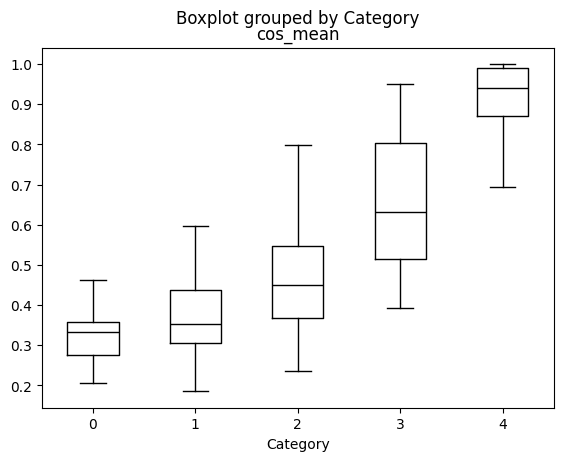

In [22]:
tc_dist.boxplot(column='cos_mean', by='Category', grid=False, showfliers=False, color='black')

<Axes: title={'center': 'cos_mean'}, xlabel='Category'>

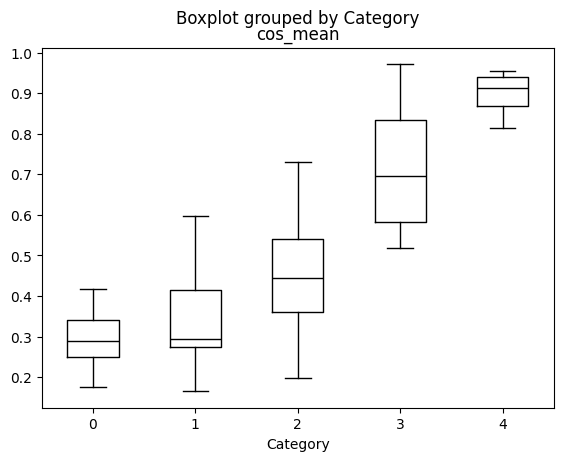

In [23]:
# INFO: このとき，Validを用いて分散表現を訓練していないことに留意すること．
vc_dist.boxplot(column='cos_mean', by='Category', grid=False, showfliers=False, color='black')

### LightGBM Model の訓練

In [24]:
import wandb

wandb.login()

wandb: Currently logged in as: masa1357. Use `wandb login --relogin` to force relogin


True

In [25]:
from wandb.integration.lightgbm import wandb_callback, log_summary
import lightgbm as lgb

In [26]:
params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_iterations': 100,
    'max_depth': 7,
    'learning_rate': 0.01,
    'num_leaves': 31
}


# wandb.config.update(params)

In [27]:
def Tree_kfold(X_train, y_train, X_valid, y_valid, params, table=None):
    oof = np.zeros((X_train.shape[0], 5))
    prediction = np.zeros((X_valid.shape[0], 5))

    accuracies = []
    f1_scores = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
        logger.info(f"Fold {fold + 1}")

        # Foldごとにデータを分割
        # train用データ：train_idxで指定されたデータ
        X_trn = X_train[train_idx]
        y_trn = y_train[train_idx]

        # valid用データ：valid_idxで指定されたデータ
        X_val = X_train[valid_idx]
        y_val = y_train[valid_idx]

        #Dataset化
        lgb_train = lgb.Dataset(X_trn, y_trn)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)


        # paramsが辞書形式か確認
        logger.info(params)
        logger.info("Train LightGBM Model")
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            valid_names=["train", "valid"],
            callbacks=[wandb_callback(), lgb.early_stopping(stopping_rounds=100)],
        )
        logger.info("Predict Validation Data")
        oof[valid_idx] = model.predict(X_val, num_iteration=model.best_iteration)
        # prediction += (
        #     model.predict(X_valid, num_iteration=model.best_iteration) / kf.n_splits
        # )

        accuracy = accuracy_score(y_val, np.argmax(oof[valid_idx], axis=1))
        logger.info(f"Fold {fold + 1} Accuracy: {accuracy}")
        f1 = f1_score(y_val, np.argmax(oof[valid_idx], axis=1), average="macro")
        logger.info(f"Fold {fold + 1} F1 Score: {f1}")
        accuracies.append(accuracy)
        f1_scores.append(f1)
        
        # log wandb
        if table is not None:
            table.add_data(
                params.get("objective"),
                params.get("num_class"),
                params.get("metric"),
                params.get("boosting_type"),
                params.get("num_iterations"),
                params.get("max_depth"),
                params.get("learning_rate"),
                params.get("num_leaves"),
                params.get("verbosity"),
                fold + 1,
                accuracy,
                f1,
            )
            wandb.log({"Fold metrics": table})
        else:
            pass
            wandb.log({"Fold": fold + 1, "Accuracy": accuracy, "F1 Score": f1})

    final_accuracy = np.mean(accuracies)
    final_f1 = np.mean(f1_scores)
    logger.info(f"Final Accuracy: {final_accuracy}")
    logger.info(f"Final F1 Score: {final_f1}")

    # predict validation data
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    logger.info("Predict Validation Data")
    valmodel = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=["train", "valid"],
        callbacks=[wandb_callback(), lgb.early_stopping(stopping_rounds=100)],
    )
    prediction = valmodel.predict(X_valid, num_iteration=model.best_iteration)
    valid_accuracy = accuracy_score(y_valid, np.argmax(prediction, axis=1))
    valid_f1 = f1_score(y_valid, np.argmax(prediction, axis=1), average="macro")
    logger.info(f"Validation Accuracy: {valid_accuracy}")
    logger.info(f"Validation F1 Score: {valid_f1}")

    wandb.log({"Final Accuracy": final_accuracy, "Final F1 Score": final_f1})
    wandb.log({"Validation Accuracy": valid_accuracy, "Validation F1 Score": valid_f1})

In [28]:
def sweep():
    #global化
    global Input_df, Valid_df, te_dist, tc_dist, ve_dist, vc_dist

    wandb.init(project="Tree-Model", config=params)
    # config = params
    config = dict(wandb.config)
    #configから"use_data"を抜き出し，削除
    use_data = config.pop("use_data")
    #input, valid 定義
    input = pd.DataFrame()
    valid = pd.DataFrame()
    #use_dataを基にデータ結合
    match use_data:
        case "ALL":
            input = pd.concat([Input_df, te_dist, tc_dist], axis=1)
            valid = pd.concat([Valid_df, ve_dist, vc_dist], axis=1)
        case "NONE":
            input = Input_df.copy()
            valid = Valid_df.copy()
        case "euc":
            input = pd.concat([Input_df, te_dist], axis=1)
            valid = pd.concat([Valid_df, ve_dist], axis=1)
        case "cos":
            input = pd.concat([Input_df, tc_dist], axis=1)
            valid = pd.concat([Valid_df, vc_dist], axis=1)
            
    X_train = input.drop(["label", "userid"], axis=1)
    X_valid = valid.drop(["label", "userid"], axis=1)
    y_train = input["label"]
    y_valid = valid["label"]

    X_train = X_train.astype(float)
    X_valid = X_valid.astype(float)
    y_train = y_train.astype(float)
    y_valid = y_valid.astype(float)
    # logger.info(f"config: {config}")
    # config = {
    #     "objective": wandb.config.objective,
    #     "num_class": wandb.config.num_class,
    #     "metric": wandb.config.metric,
    #     # --sweep_config--
    #     "boosting_type": wandb.config.boosting_type,
    #     "num_iterations": wandb.config.num_iterations,
    #     "max_depth": wandb.config.max_depth,
    #     "learning_rate": wandb.config.learning_rate,
    #     "num_leaves": wandb.config.num_leaves,
    #     "verbosity": -1,
    # }
    columns = [
        "objective",
        "num_class",
        "metric",
        "boosting_type",
        "num_iterations",
        "max_depth",
        "learning_rate",
        "num_leaves",
        "verbosity",
        "accuracy",
        "f1",
    ]
    # table = wandb.Table(columns=columns)
    Tree_kfold(
        X_train.values,
        y_train.values,
        X_valid.values,
        y_valid.values,
        config,
    )

In [29]:
with open(BASE_PATH / "config" / "config.yaml", "r") as f:
    config = yaml.safe_load(f)
config = dict(config)

In [30]:
config

{'name': 'Tree_Model_use_vector_distance',
 'description': 'Tree Model',
 'method': 'random',
 'metric': {'name': 'F1 Score', 'goal': 'maximize'},
 'parameters': {'objective': {'value': 'multiclass'},
  'num_class': {'value': 5},
  'metric': {'value': 'multi_logloss'},
  'verbosity': {'value': -1},
  'boosting_type': {'values': ['gbdt', 'dart']},
  'num_iterations': {'min': 1000, 'max': 10000},
  'max_depth': {'min': 3, 'max': 10},
  'learning_rate': {'min': 0.01, 'max': 0.1},
  'num_leaves': {'min': 10, 'max': 100},
  'class_weight': {'values': ['None', 'balanced']},
  'use_data': {'values': ['euc', 'cos', 'ALL', 'NONE']}}}

In [31]:
sweep_id = wandb.sweep(sweep=config, project="Tree-Model")

wandb.agent(sweep_id, function=sweep, count=50)

Create sweep with ID: gszu4ra5
Sweep URL: https://wandb.ai/masa1357/Tree-Model/sweeps/gszu4ra5


wandb: Agent Starting Run: txv0voqx with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.029811249466095105
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8482
wandb: 	num_leaves: 62
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:42:03,056 : python.util : INFO : 10 : Fold 1
2024-08-15 02:42:03,057 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:03,058 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' w

Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:04,366 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:04,369 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 02:42:04,372 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 02:42:04,373 : python.util : INFO : 10 : Fold 2
2024-08-15 02:42:04,374 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:04,374 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[309]	train's multi_logloss: 1.79165e-05	valid's multi_logloss: 1.90301e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:08,044 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:08,047 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 02:42:08,050 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 02:42:08,051 : python.util : INFO : 10 : Fold 3
2024-08-15 02:42:08,052 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:08,052 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[745]	train's multi_logloss: 1.61651e-05	valid's multi_logloss: 2.62955e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:09,341 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:09,344 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 02:42:09,347 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 02:42:09,347 : python.util : INFO : 10 : Fold 4
2024-08-15 02:42:09,348 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:09,349 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[438]	train's multi_logloss: 1.73668e-05	valid's multi_logloss: 3.18718e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:10,386 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:10,389 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 02:42:10,392 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 02:42:10,392 : python.util : INFO : 10 : Fold 5
2024-08-15 02:42:10,393 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:10,394 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[304]	train's multi_logloss: 1.82424e-05	valid's multi_logloss: 1.84463e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:11,361 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:11,364 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 02:42:11,367 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 02:42:11,367 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 02:42:11,368 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 02:42:11,369 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[256]	train's multi_logloss: 1.95941e-05	valid's multi_logloss: 2.70875e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:13,290 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 02:42:13,291 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[541]	train's multi_logloss: 1.35165e-05	valid's multi_logloss: 1.73466e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▃▄▁▂▂▃▄▅▅▆▇▇█▁▂▃▃▄▅▆▁▂▃▄▄▂▂▃▄▁▂▃▃▄▅▅▆
train_multi_logloss,▃▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
valid_multi_logloss,▃▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: tt79xt8z with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.055291970145420845
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8468
wandb: 	num_leaves: 12
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:42:24,965 : python.util : INFO : 10 : Fold 1
2024-08-15 02:42:24,966 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:24,967 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' w

Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:25,980 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:25,982 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 02:42:25,985 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 02:42:25,986 : python.util : INFO : 10 : Fold 2
2024-08-15 02:42:25,987 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:25,987 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[169]	train's multi_logloss: 1.77723e-05	valid's multi_logloss: 1.90495e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:27,835 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:27,839 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 02:42:27,842 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 02:42:27,843 : python.util : INFO : 10 : Fold 3
2024-08-15 02:42:27,844 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:27,844 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[422]	train's multi_logloss: 1.59755e-05	valid's multi_logloss: 2.65463e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:28,540 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:28,544 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 02:42:28,547 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 02:42:28,547 : python.util : INFO : 10 : Fold 4
2024-08-15 02:42:28,548 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:28,549 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[141]	train's multi_logloss: 1.93112e-05	valid's multi_logloss: 3.24529e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:29,263 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:29,268 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 02:42:29,270 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 02:42:29,271 : python.util : INFO : 10 : Fold 5
2024-08-15 02:42:29,272 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:29,272 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[160]	train's multi_logloss: 1.82097e-05	valid's multi_logloss: 1.83955e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:29,986 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:29,989 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 02:42:29,993 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 02:42:29,994 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 02:42:29,994 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 02:42:29,995 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[141]	train's multi_logloss: 1.90531e-05	valid's multi_logloss: 2.63432e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:32,011 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 02:42:32,012 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[289]	train's multi_logloss: 1.34209e-05	valid's multi_logloss: 1.75345e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▂▃▄▄▁▂▃▃▄▅▅▆▇▇█▁▂▃▄▁▂▂▃▄▄▁▂▃▃▄▁▂▃▃▄▅▅▆
train_multi_logloss,▄▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
valid_multi_logloss,▅▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁█▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: u84xws3b with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.05008589597969481
wandb: 	max_depth: 10
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 5588
wandb: 	num_leaves: 32
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:42:41,939 : python.util : INFO : 10 : Fold 1
2024-08-15 02:42:41,941 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 5588, 'max_depth': 10, 'learning_rate': 0.05008589597969481, 'num_leaves': 32, 'class_weight': 'None'}
2024-08-15 02:42:41,942 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

In [ ]:
wandb.finish()